# DeepCNN Test Notebook

In [1]:
import os
workspace = "/workspace"
os.chdir(workspace)

import mne
import json
import argparse
import oyaml as yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from tqdm import tqdm
from torch.nn import MSELoss

from src import GetLoader
from glob import glob
from src import read_config, plot_single_channel, plot_topomap, show_morlet
from src.model.deepcnn import DeepCNN
from src.train import Meter, LossMeter, MetricMeter
from src.train import signal_to_noise_ratio, pearson_correlation_coefficient

In [9]:
params = {
    "config_path": "cfg/deepcnn.yml",
    "data_path": "data/eegmmidb/preprocessing/noiseless_std.pth",
    "ckpt_path": "runs/deepcnn/eegmmidb/multiquadric/noiseless_std/model.pt",
    "batch_size": 64
}

In [6]:
org_ch = read_config("data/eegmmidb/ch_order.json")
mask_ch = [int(ch) for ch in org_ch.keys()]
mask_ch

[0, 2, 12, 27, 35, 50, 60, 62]

In [7]:
# SEED & Device set
torch.manual_seed(42)

if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    cudnn.benchmark = True
    device = "cuda"
else:
    device = "cpu"

In [10]:
# Model set
model_kwargs = read_config(params["config_path"])
model = DeepCNN(model_kwargs).to(device)

checkpoint = torch.load(params["ckpt_path"])
new_checkpoint = {k[7:]: v for k, v in checkpoint.items()}

model.load_state_dict(new_checkpoint)
model.eval()

DeepCNN(
  (en_module): Sequential(
    (0): Conv2d(1, 64, kernel_size=(13, 5), stride=(2, 2), padding=(6, 2))
    (1): Conv2d(64, 64, kernel_size=(13, 5), stride=(2, 2), padding=(6, 2))
    (2): Conv2d(64, 64, kernel_size=(13, 5), stride=(2, 2), padding=(6, 2))
  )
  (de_module): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(13, 9), stride=(2, 2), padding=(6, 4), output_padding=(1, 1))
    (1): ConvTranspose2d(64, 64, kernel_size=(13, 9), stride=(2, 2), padding=(6, 4), output_padding=(1, 1))
    (2): ConvTranspose2d(64, 64, kernel_size=(13, 9), stride=(2, 2), padding=(6, 4), output_padding=(1, 1))
    (3): ConvTranspose2d(64, 64, kernel_size=(13, 5), stride=(1, 1), padding=(6, 2))
    (4): ConvTranspose2d(64, 1, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0))
  )
)

In [11]:
# Test data
test_loader = GetLoader(
    params["data_path"],
    dataset_mode = "test",
    batch_size = params["batch_size"],
    shuffle = False,
    pin_memory = True,
    num_workers = 2
).get_loader()

In [8]:
# Test process
with torch.no_grad():
    loss_meter = LossMeter(MSELoss())
    snr_meter = MetricMeter(signal_to_noise_ratio)
    pcc_meter = MetricMeter(pearson_correlation_coefficient)
    
    for lr_eeg, hr_eeg in tqdm(test_loader):
        lr_eeg = lr_eeg.to(device)
        hr_eeg = hr_eeg.to(device)
        
        sr_eeg = model(lr_eeg)
        
        sr_eeg[..., mask_ch] = hr_eeg[..., mask_ch]
        
        # Loss & Metric value calculation
        loss_meter.calculate(sr_eeg, hr_eeg, mode = "test")
        snr_meter.calculate(sr_eeg, hr_eeg)
        pcc_meter.calculate(sr_eeg, hr_eeg)
        
print("Loss => {:.5f}".format(loss_meter.value()))
print("SNR => {:>3.3f}".format(snr_meter.value()))
print("PCC => {:.3f}".format(pcc_meter.value()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:43<00:00,  1.08it/s]

Loss => 0.33323
SNR => 4.781
PCC => 0.817


In [12]:
# # Log save (MSE, SNR, PCC)
log_path = "runs/deepcnn/eegmmidb/log.csv"

log_df = pd.DataFrame({
    "Interpolate": ["Multiquadric"],
    "Noise ratio": ['Noiseless'],
    "MSE": [0.232],
    "SNR": [6.816],
    "PCC": [0.877],
    "Mask": ["N"]
})

if os.path.exists(log_path):
    log_df.to_csv(log_path, mode = "a", header = False, index = False)
else:
    log_df.to_csv(log_path, index = False)

In [18]:
@torch.no_grad()
def eeg_super_resolution(model, lr_eeg, hr_eeg, mask_ch, device):
    lr_eeg = lr_eeg.to(device)
    
    sr_eeg = model(lr_eeg).detach().cpu()
    sr_eeg[..., mask_ch] = hr_eeg[..., mask_ch]
    
    sr_eeg = sr_eeg.detach().cpu()
    return sr_eeg

In [19]:
lr_eeg, hr_eeg = next(iter(test_loader))

sr_eeg = eeg_super_resolution(model, lr_eeg, hr_eeg, mask_ch, device)

lr_eeg = lr_eeg.squeeze(1).permute(0, 2, 1)
hr_eeg = hr_eeg.squeeze(1).permute(0, 2, 1)
sr_eeg = sr_eeg.squeeze(1).permute(0, 2, 1)

In [33]:
ch_list = pd.read_csv("data/eegmmidb/ch_list.csv")["ch_names"].tolist()

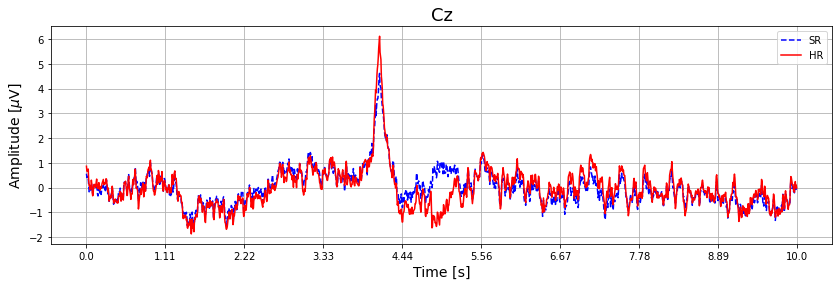

In [34]:
p = 10
ch = 10
time_len = lr_eeg.shape[-1]
sfreq = 160
ch_name = ch_list[ch]

plot_single_channel(
#     lr_eeg = lr_eeg[p, ch],
    sr_eeg = sr_eeg[p, ch],
    hr_eeg = hr_eeg[p, ch],
    time_len = time_len,
    sfreq = sfreq,
    ch_name = ch_name,
#     save_path = "signal_snr_0.1_mask_p_100_ch_100.jpg"
)

In [35]:
info = mne.create_info(ch_list, 160, "eeg")
montage = read_config("data/Montage/64_ch_system.pkl")
montage

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 64 channels>

In [36]:
lr_evok = mne.EvokedArray(lr_eeg[p].numpy(), info)
lr_evok.set_montage(montage)

sr_evok = mne.EvokedArray(sr_eeg[p].numpy(), info)
sr_evok.set_montage(montage)

hr_evok = mne.EvokedArray(hr_eeg[p].numpy(), info)
hr_evok.set_montage(montage)

Condition,
Data kind,average
Timepoints,1600 samples
Channels,64 channels
Number of averaged epochs,1
Time range (secs),0.0 – 9.99375
Baseline (secs),off


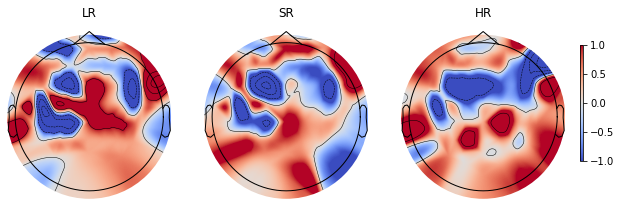

In [37]:
raw_eeg = {"LR": lr_evok, "SR": sr_evok, "HR": hr_evok}

plot_topomap(raw_eeg, figsize = (10, 4))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


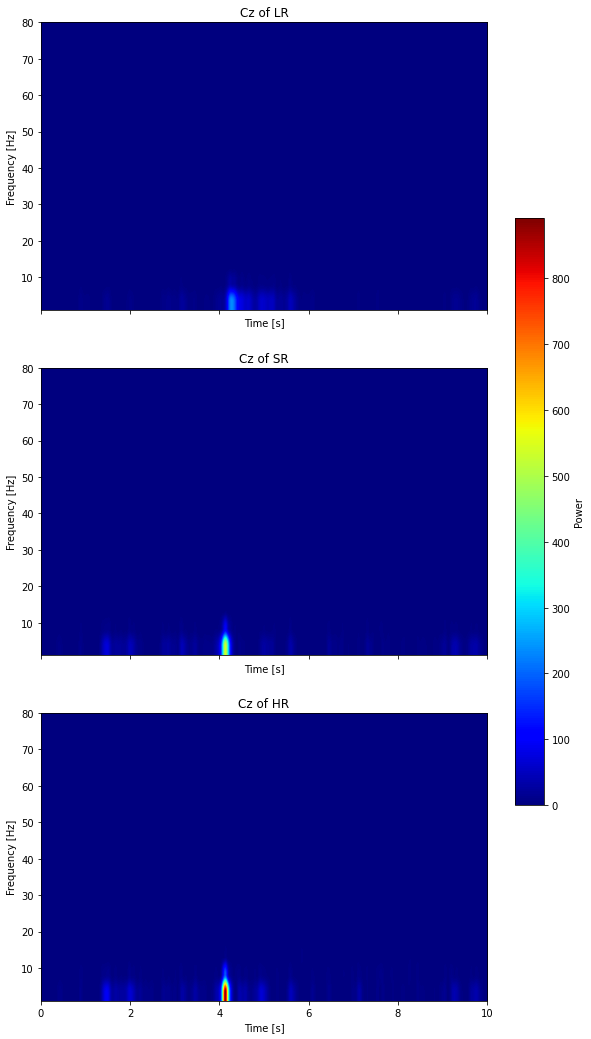

In [38]:
lr_raw = lr_evok.copy().pick_channels([ch_list[ch]])
sr_raw = sr_evok.copy().pick_channels([ch_list[ch]])
hr_raw = hr_evok.copy().pick_channels([ch_list[ch]])
raw_eeg = {"LR": lr_raw, "SR": sr_raw, "HR": hr_raw}
freqs = np.linspace(1, 80, 16)

show_morlet(raw_eeg, freqs, cmap = "jet")

In [2]:
import numpy as np
import torch

In [3]:
x1 = np.linspace(-1, 1, 101)
x2 = 0.5*np.cos(np.pi*x1) + 0.5*np.cos(4*np.pi*(x1+1)) # <- decision boundary

samples = 200
x = np.random.uniform(-1, 1, (samples, 2))
for i in range(samples):
    if i < samples//2:
        x[i,1] = np.random.uniform(-1, 0.5*np.cos(np.pi*x[i,0]) + 0.5*np.cos(4*np.pi*(x[i,0]+1)))
    else:
        x[i,1] = np.random.uniform(0.5*np.cos(np.pi*x[i,0]) + 0.5*np.cos(4*np.pi*(x[i,0]+1)), 1)

steps = 100
x_span = np.linspace(-1, 1, steps)
y_span = np.linspace(-1, 1, steps)
xx, yy = np.meshgrid(x_span, y_span)
values = np.append(xx.ravel().reshape(xx.ravel().shape[0], 1),
                   yy.ravel().reshape(yy.ravel().shape[0], 1),
                   axis=1)

tx = torch.from_numpy(x).float()
ty = torch.cat((torch.zeros(samples//2,1), torch.ones(samples//2,1)), dim=0)

In [6]:
ty.shape

torch.Size([200, 1])

In [9]:
import sys

sys.stdout.write("1 + 1은 귀요미")
sys.stdout.flush()

1 + 1은 귀요미